# Spark - Scikit-learn benchmark

## Introduction

In this report, we detail the analysis that has been conducted in order to benchmark the two well-known machine learning libraries: Spark, and Scikit-learn.

We were looking for a big dataset available on the internet, with an easy-enough task to solve. We found the [OpenAddresses - Europe](https://www.kaggle.com/openaddresses/openaddresses-europe) dataset.

We managed to rearrange the original datasets (separate CSV files) into one big CSV that contains data for five countries: Germany, Spain, France, Portugal and Italy.

# Problem A

## Context

Here we choose a rather simple problem. We possess the latitude `LAT` and longitude `LON` of 58 millions addresses in Europe. We want to predict the country of the localization.

The following graph shows the sample data used for this task:

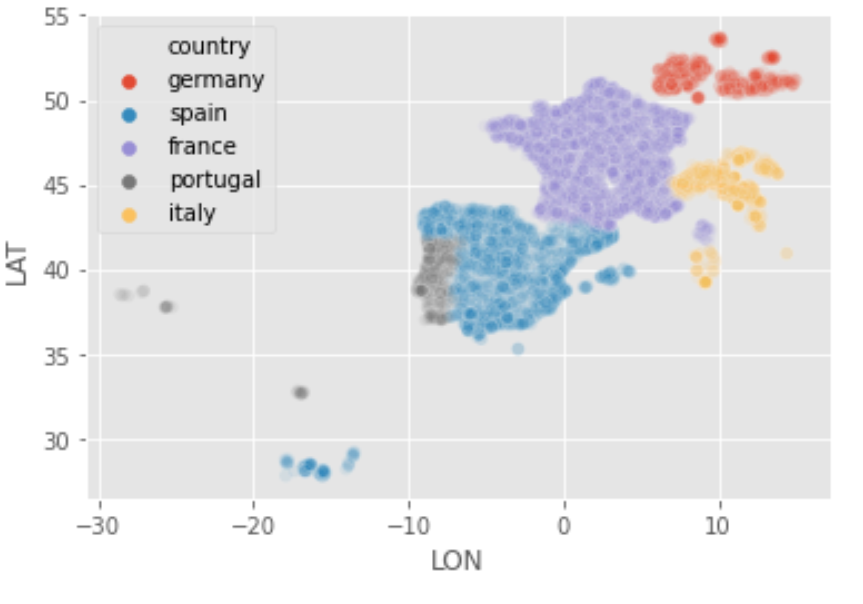

In [4]:
from IPython.display import Image

Image(filename='countries_lat_lon.png', width=400)

## Code

The following roughly details the code used to create a Scikit-learn model, and a Spark pipeline.  
These two procedures are benchmarked against each other in the duration (time) dimension.

### Scikit-learn

```python
from sklearn.ensemble import RandomForestClassifier as RfSk
from sklearn.preprocessing import LabelEncoder

X = df[['LON', 'LAT']]
y = LabelEncoder().fit_transform(df["country"])

clf.fit(X, y)
```

### Spark
```python
def create_pipeline(df):
    label_indexer = StringIndexer(inputCol="country", outputCol="label", handleInvalid="skip").fit(df)
    label_converter = IndexToString(
        inputCol="prediction", 
        outputCol="predictedLabel",
        labels=label_indexer.labels
    )
    assembler = VectorAssembler(
        inputCols=["LON", "LAT"],
        outputCol="features"
    )
    rf = RandomForestClassifier(
        numTrees=50, 
        maxDepth=2, 
        labelCol="label", 
        seed=42
    )
    pipeline = Pipeline(
        stages=
        [
            label_indexer, 
            assembler,
            rf,
            label_converter
        ]
    )
    return pipeline
```

### Results

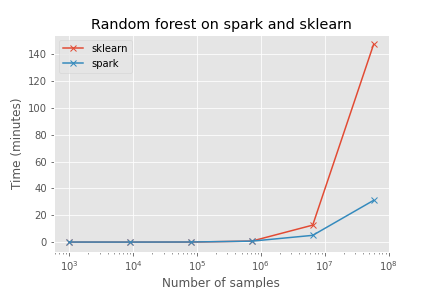

In [7]:
Image(filename='benchmark_rf_full.png', width=400)

The following chart shows a subset of previous numbers which allows one to appreciate the difference with 6 million samples: it goes from 5 minutes (Spark) to 12.5 minutes (Scikit-learn).

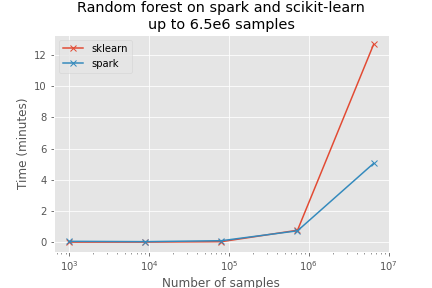

In [9]:
Image(filename="benchmark_rf_10^7.png", width=400)

In this case, we can see that Spark outperforms Scikit-learn, very visible, based on a dataset with more that approximately 1 million samples.

# Problem B

## Context

In this case, we only leverage the `STREET` column in the dataset to predict the country. Hence, we want to build algorithms that can recognize the language of the street in order to correctly classify. Since we don't have two countries sharing the same language, this task should be feasible based on nouns such as "street", "avenue" etc.

In order to compare both implementations, we should chose the same algorithm. However, we didn't find the same machine learning and linear algebra capabilities in both libraries. Hence, we use a slightly different implementation for spark, with a Principal Component Analysis (PCA) component, and an SVD one for scikit-learn.

## Code

### Scikit-learn

```python
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

def fit_predict_sk(data):
    tfidf = TfidfVectorizer(max_features=2**10)

    train, test = train_test_split(data)

    pipeline = make_pipeline(tfidf, TruncatedSVD(5), RandomForestClassifier(100))

    pipeline.fit(train["STREET"].values, train["country"])
    y_pred = pipeline.predict(test["STREET"].values)
```

### Spark

```python
def fit_predict(df):
    label_indexer = StringIndexer(inputCol="country", outputCol="label").fit(df)

    pipeline = Pipeline(stages=[
        label_indexer,
        Tokenizer(inputCol="STREET", outputCol="words"),
        HashingTF(inputCol="words", outputCol="rawFeatures", 
                          numFeatures=20),
        IDF(inputCol="rawFeatures", outputCol="tfidf_features"),
        PCA(k=2, inputCol='tfidf_features', outputCol='pca_features'),
        RandomForestClassifier(featuresCol='pca_features'),
        IndexToString(inputCol="prediction", outputCol="predictedLabel", 
                      labels=label_indexer.labels)
    ])

    model = pipeline.fit(df)
    predictions = model.transform(df)
    evaluator = MulticlassClassificationEvaluator(
        labelCol='label', predictionCol='prediction', metricName='accuracy'
    )
    accuracy = evaluator.evaluate(predictions)
    print("accuracy: ", accuracy)
    return accuracy
```

## Results

the x-axis represents the number of samples, and the y-axis the time in minutes:

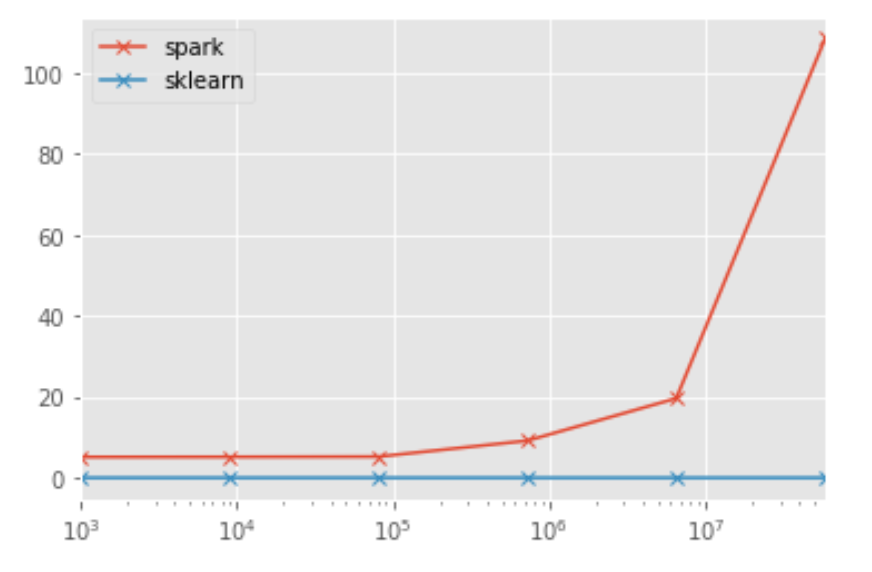

In [5]:
Image(filename='benchmark_text.png', width=400)

Here, we can see that the Spark implementation is much slower. This made us realize that the algorithms we chose for each implementation are widely different in terms of complexity, which creates large differences. Hence, the comparison here may not really be suitable for a rigorous benchmark.

# Conclusion

Given the data we have, it is complicated to conclude about the performance of both frameworks.  

Given the first problem, we can say that the Spark implementation seems to perform better from approximately one million samples. The second results are dubious, hence inconclusive.